<span style="font-family:Times; font-size:2em;">
Importing Libraries:

pandas: DataFrame, basic stats

matplotlib: plotting

numpy: Arrays and math functions

sklearn: Machine Learning, data preparation
</span>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


<span style="font-family:Times; font-size:2em;">
Reading data output from maindriver_newton.C.
Removes the header.
Converts all columns from string to the correct datatype.
Creates the Label column.
Splits data into a train sample and a test sample.
Drops constituents below subleading particle for robustness.
X_tru = p_T^{pythia}/N_Trk
</span>

In [3]:
def get_data(filename, names_=['p_T', 'Eta', 'Phi', 'p_T-corr', 'N-Trk', 'Angularity', 'Mean-p_T', 'p_T_1', 'p_T_2', 'p_T_3', 'p_T_4', 'p_T_5', 'X_tru']):
       '''
       Takes a filename and the names of the columns in the CSV file. Returns a DataFrame.
       '''
       dat = pd.read_csv(filename, names=names_)
       dat = dat[dat.p_T!='p_T']
       return dat

def prepare_data(dat, label_bins=[-1, 0.1,10000000], labels_=[1,2]):

       dat = dat.astype({'p_T': np.float64, 'Eta': np.float64, 'Phi': np.float64, 'p_T-corr': np.float64, 'N-Trk': np.int64, 'Angularity': np.float64, 'Mean-p_T': np.float64,'p_T_1': np.float64, 'p_T_2': np.float64, 'p_T_3': np.float64, 'p_T_4': np.float64, 'p_T_5': np.float64, 'X_tru': np.float64})
       
       dat["X_tru_sum"] = dat['X_tru']*dat['N-Trk']/dat['p_T']
       
       dat['Label'] = pd.cut(dat["X_tru_sum"], bins=label_bins, labels=labels_)
       
       dat['Label']=dat['Label'].astype(np.int64)
       
       return dat
       
def split_data(dat):
       train, test = train_test_split(dat, test_size=0.2, random_state=42)
       train.drop(['p_T_3', 'p_T_4', 'p_T_5'], 1, inplace=True)
       return train, test

dat = get_data("../Generator Output/pbgOut1-6.csv")
dat = prepare_data(dat, [-1, 0.3, 10000000], [0,1])
train, test = split_data(dat)



<span style="font-family:Papyrus; font-size:2em;">
Adds a column to train, "X_tru_sum", that represents the total momentum fraction from pythia in the FastJet jet. Plots a histogram of this variable.
</span>

0.0


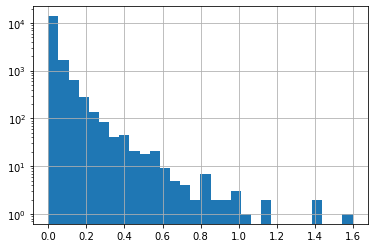

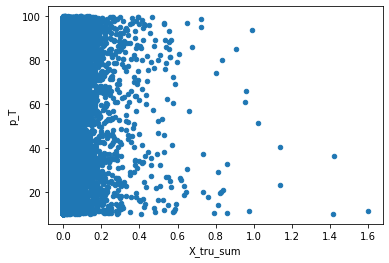

In [4]:
train['X_tru_sum'].hist(bins=30)
plt.semilogy()
train.plot('X_tru_sum', 'p_T', 'scatter')

print(len(train.loc[train['X_tru_sum']>10])/len(train))

<span style="font-family:Papyrus; font-size:2em;">
Making Dataframes X, Y that will become the inputs to the machine learning. We drop "N-Trk", "X_tru", "X_tru_sum", "Label" for robustness in the case of "N-Trk" and to hide the labels from our algorithm. X is the feature set and Y is the Label set. 
</span>

In [5]:
def split_feat_label(data, drop_labels=['N-Trk', 'X_tru', 'X_tru_sum', 'Label'], label_='X_tru_sum'):
    X = data.drop(drop_labels, 1)
    Y=data['Label']
    return X, Y

X, Y = split_feat_label(train)

<span style="font-family:Papyrus; font-size:2em;">
Plotting the "Mean-p_T for the Fake and 10% True jets."
</span>

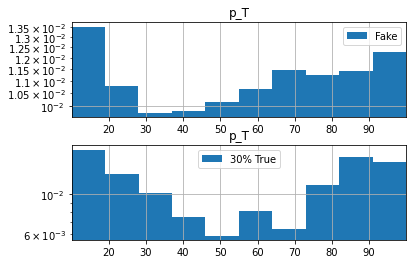

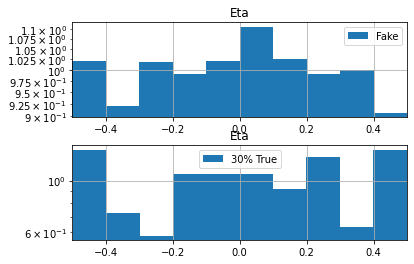

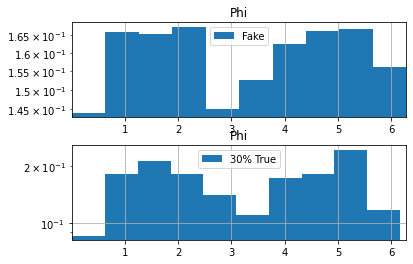

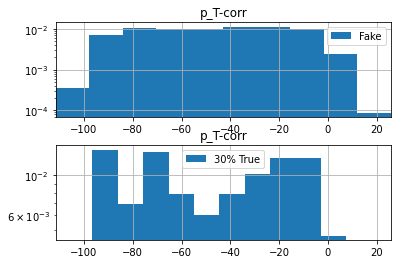

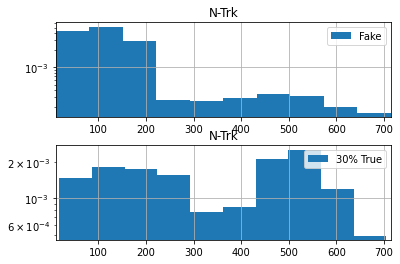

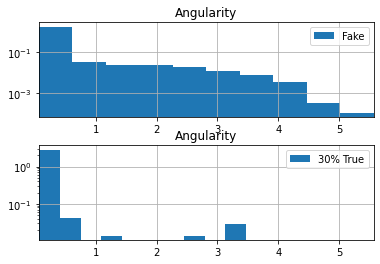

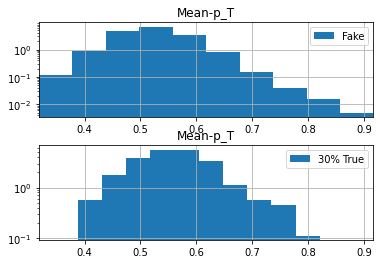

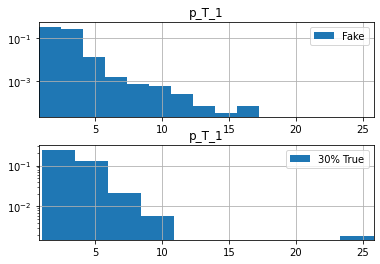

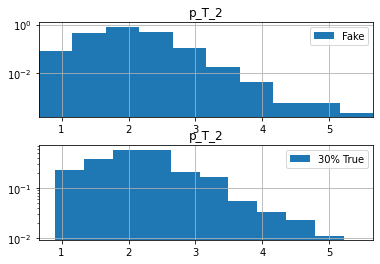

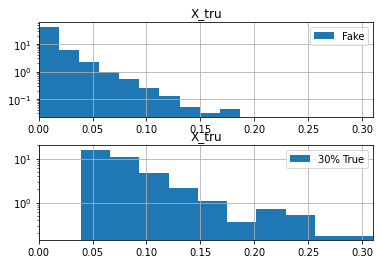

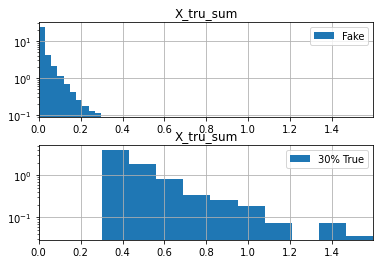

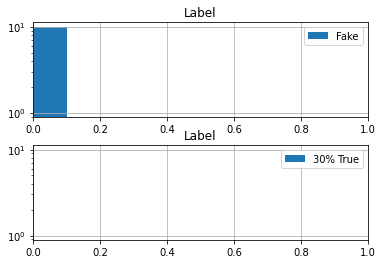

In [6]:
def plot_population(feat):
    fig, ax_ = plt.subplots(2)
    minx = train[feat].min()
    maxx = train[feat].max()
    train.loc[train['Label']==0].hist(feat, density=True,ax = ax_[0], label="Fake")
    ax_[0].set_xlim(minx, maxx)
    ax_[0].legend(loc='best')
    train.loc[train['Label']==1].hist(feat, density=True,ax = ax_[1], label="30% True")
    ax_[1].set_xlim(minx, maxx)
    ax_[1].legend(loc='best')
    ax_[0].semilogy()
    ax_[1].semilogy()



for cols in train.columns:
    plot_population(cols)

<span style="font-family:Papyrus; font-size:2em;">
Plotting the correlations between variables. I-Spy: Look for variables that are not that correlated with other variables(weakly correlated).
</span>

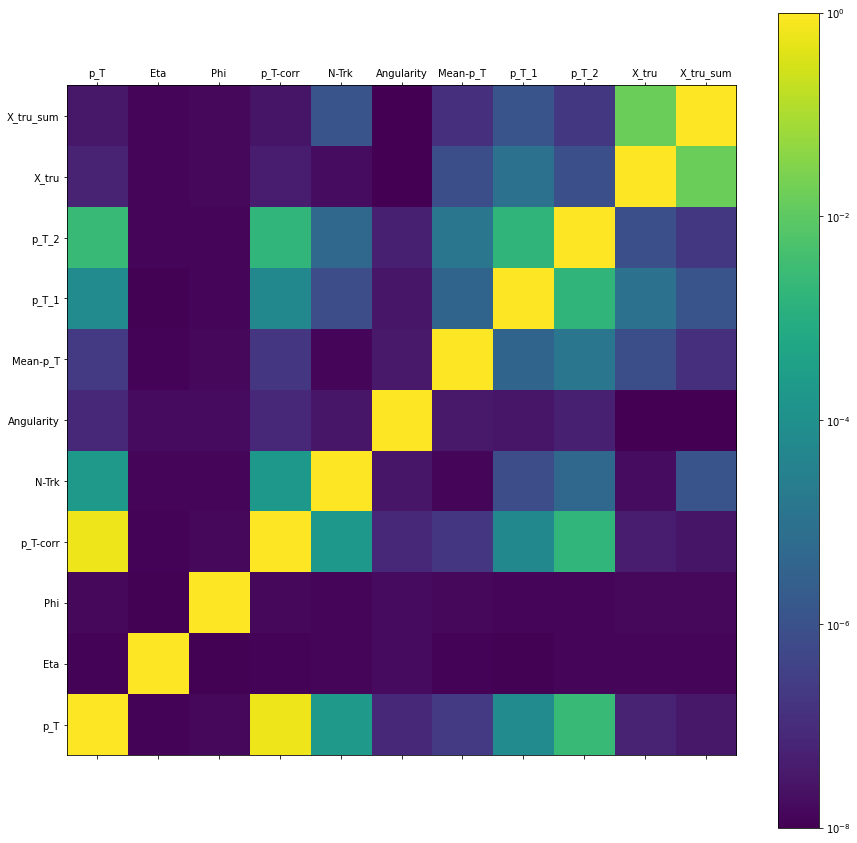

In [7]:
from matplotlib import cm, colors
def plot_corr_mat(train):
    fig,ax = plt.subplots(1,figsize=(15,15))
    ax.matshow(train.corr())
    fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=0.00000001, vmax=1)), ax=ax)
    cols = train.columns
    plt.xticks(np.linspace(0, len(train.columns)-2, len(train.columns)-1), cols.drop('Label'))
    plt.yticks(np.linspace(0, len(train.columns)-2, len(train.columns)-1), cols.drop('Label'))
    plt.ylim(-0.5, 10.5)
    plt.xlim(-0.5, 10.5)
plot_corr_mat(train)

Create a Decision Tree Classifier [See here](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248 ). It then fits the features, X, to the labels, Y.


In [8]:
clf = DecisionTreeClassifier()
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Now, let's print the feature importance for the simple Decision Tree. I-Spy: We want to look for features that we might expect to be important and those that surprise us. We also want to be wary of variables like Eta and Phi that should have no importance whatsoever according to the physics. High feature importances for these variables indicate an overfitting problem: it's learning the quirks of Pythia moreso than it generalizes to basic physics. We will see that this serves as a good comparison to the Random Forest Classifier since that is a forest of decision trees. A random forest will be less susceptible to overfitting.

In [9]:
print(X.columns)
clf.feature_importances_
i=0
for col in X.columns:
    print("%s: %f"%(col, clf.feature_importances_[i]))
    i+=1

Index(['p_T', 'Eta', 'Phi', 'p_T-corr', 'Angularity', 'Mean-p_T', 'p_T_1',
       'p_T_2'],
      dtype='object')
p_T: 0.135863
Eta: 0.105018
Phi: 0.106965
p_T-corr: 0.112596
Angularity: 0.127091
Mean-p_T: 0.137511
p_T_1: 0.142746
p_T_2: 0.132209


Now we make the Random Forest Classifier and we specify some hyperparameters(parameters that arre not learned during the fitting process). The max_depth controls how specific we can get with our questions. Think the 20 questions effect: with 20 questions you can guess anything. By limiting the depth we intentionally ignore less important information in favor of the most efficient feature decisions. The criterion ["entropy'|'gini'] determines the optimization factor. I would like to implement a custom metric that accounts for efficiency of true jets. random_state is just a seed.

In [10]:
clf = RandomForestClassifier(max_depth=3, criterion='gini',class_weight='balanced', random_state=42)
clf.fit(X, Y)
params = {'class_weight':({0:1, 1:10}, 'balanced')}
gcv = GridSearchCV(clf, params)
gcv.fit(X,Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             i

In [11]:
print(gcv.best_params_)

{'class_weight': {0: 1, 1: 10}}


Feature importances for the random forest. We see that when we have more perspectives(100 decision trees) we squash unimportant variables like Eta, Phi, and p_T-corr.

In [12]:
i=0
for col in X.columns:
    print(col, clf.estimators_[5].feature_importances_[i])
    i+=1

p_T 0.2202284856148917
Eta 0.0
Phi 0.016488736107297015
p_T-corr 0.0
Angularity 0.1102100437040437
Mean-p_T 0.05557456302984348
p_T_1 0.2649128713132194
p_T_2 0.3325853002307048


Here we plot the decision tree structure of one of the trees. It shows us the cuts made and the impurity/entropy/efficiency.

{'bootstrap': True, 'class_weight': {0: 1, 1: 10}, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


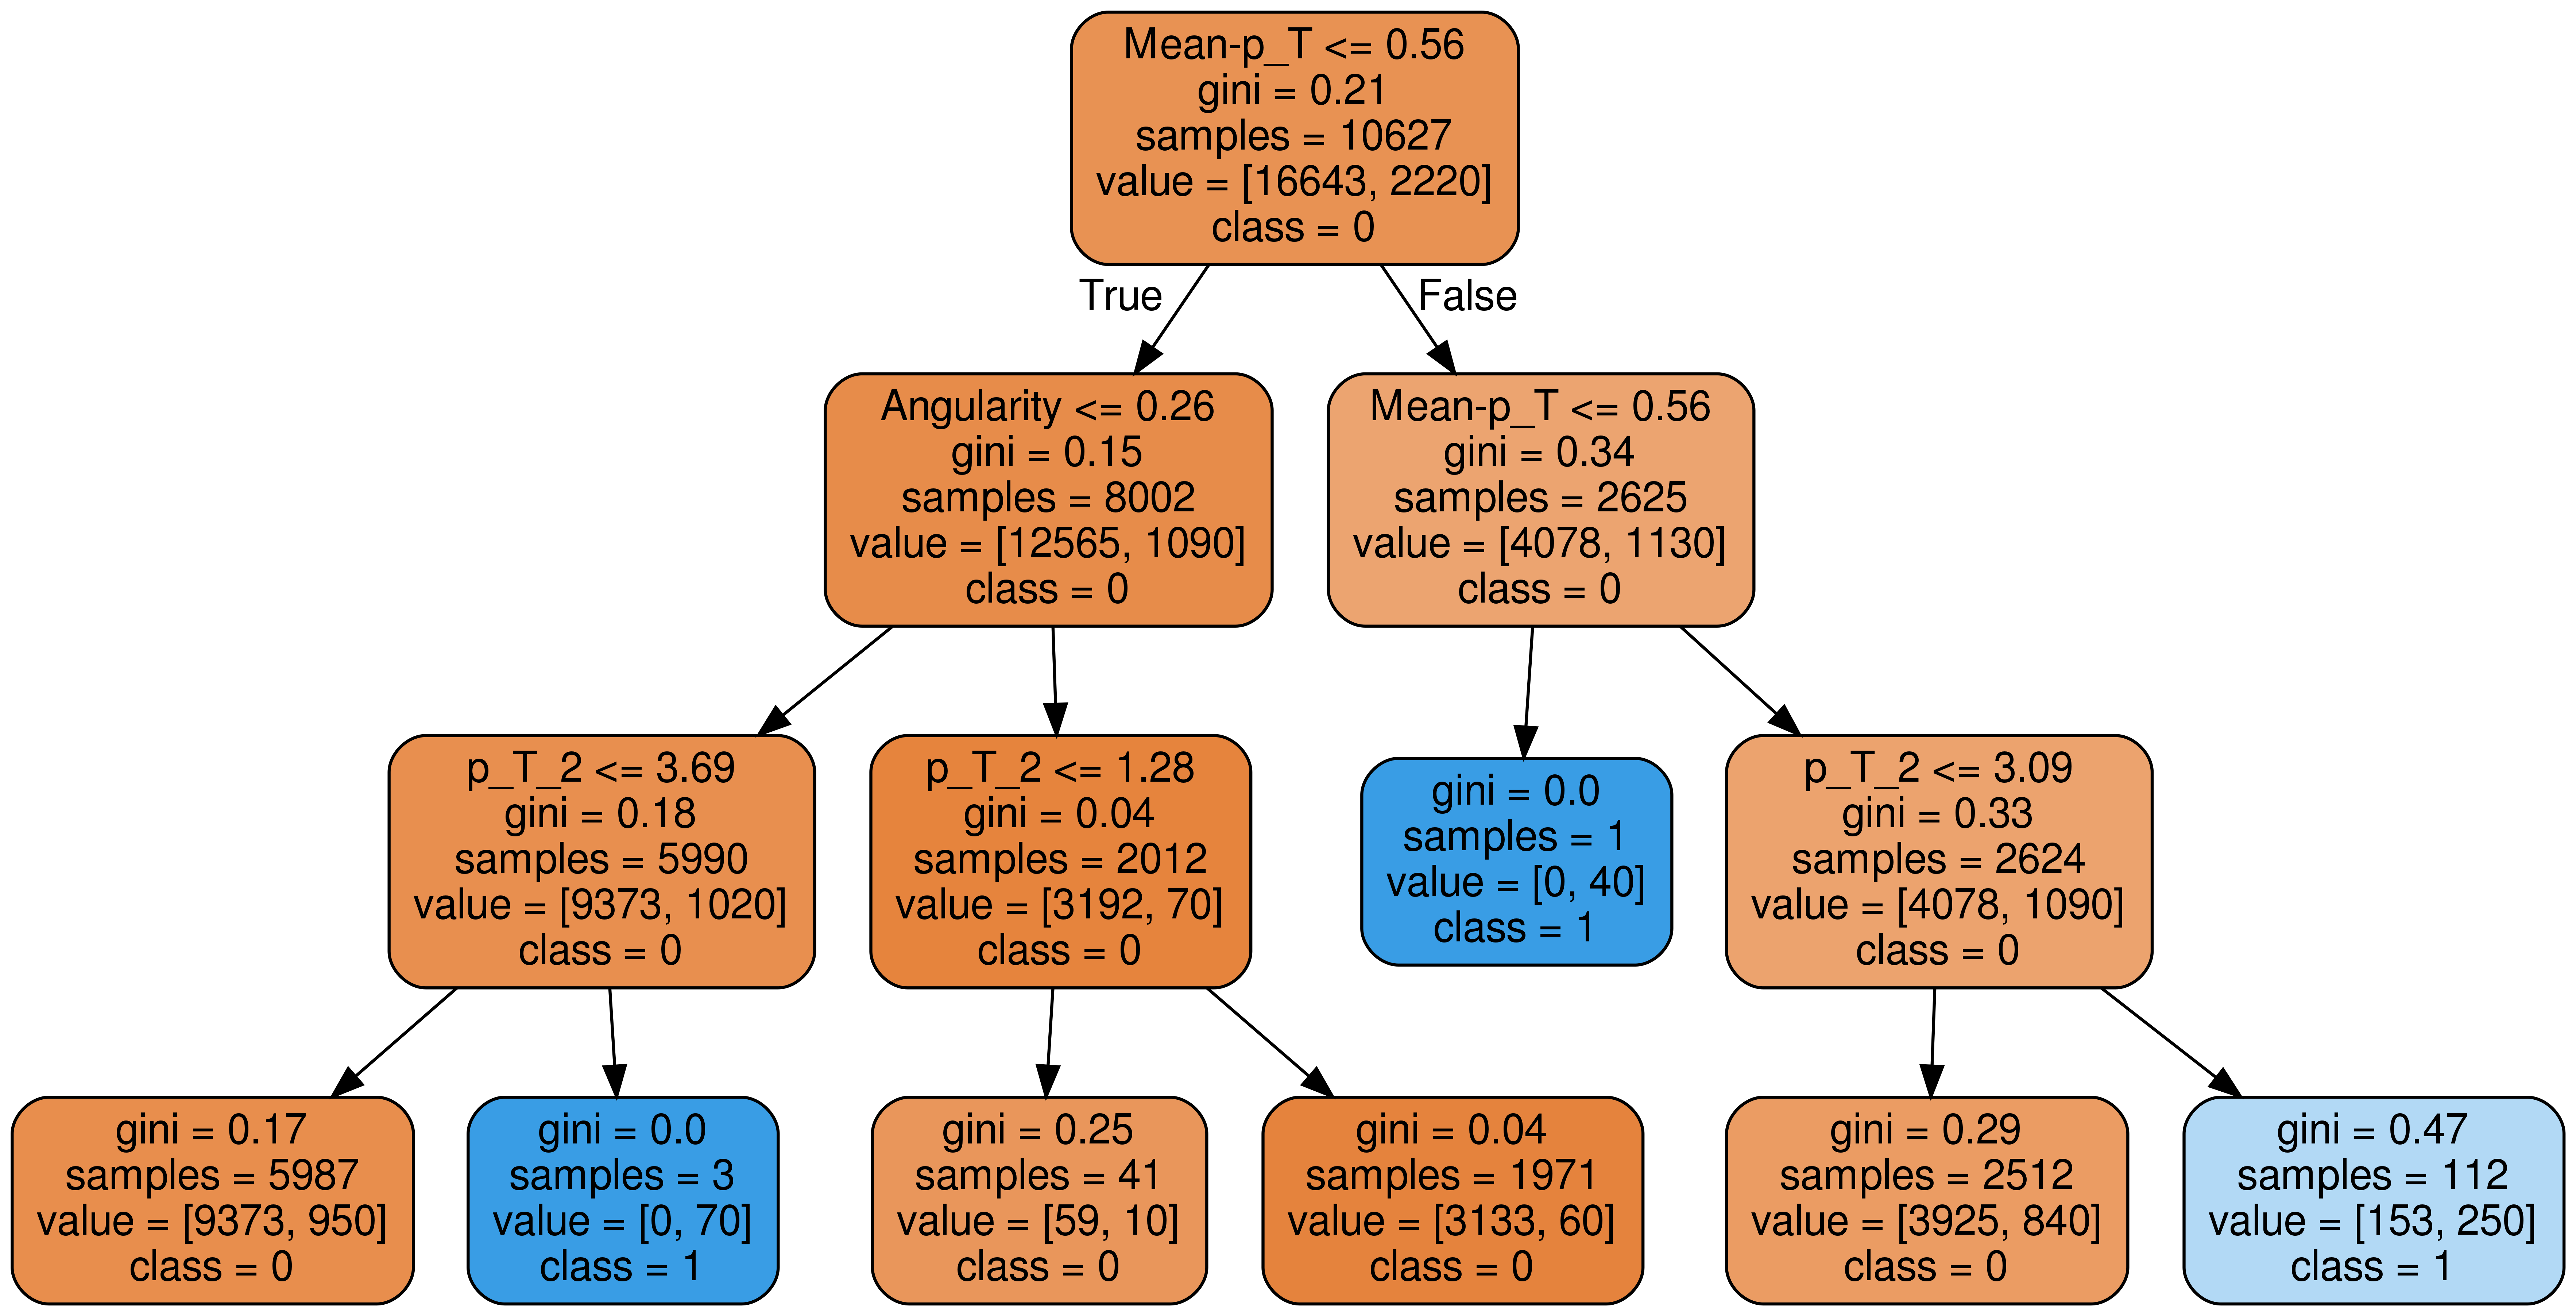

In [13]:

print(gcv.best_estimator_.get_params())
# Extract single tree
estimator = gcv.best_estimator_.estimators_[9]
#estimator.fit(X, Y)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = list(map(lambda x:str(x), dat['Label'].unique())),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


In [1]:
n_classes=2

plot_colors = "kk"
marker_style = "+x"
plot_step = 0.05

ar = np.array([np.ones(len(X.columns))*k for k in range(len(X.columns))], dtype=int)
subar = np.tile(range(len(X.columns)), len(X.columns))
enar = list(map(lambda x: list(x),zip(ar.ravel(), subar)))
print(enar)

f = plt.figure(figsize=(30,30))

for pairidx, pair in enumerate(enar):
    # We only take the two corresponding features
    print(pair)
    X_ = X.iloc[:,pair]
    y = Y

    # Train
    clf = RandomForestClassifier(max_depth=5, criterion='gini',class_weight='balanced', random_state=42)
    clf.fit(X_,y)
    # Plot the decision boundary
    plt.subplot(len(X.columns), len(X.columns), pairidx + 1)
    print(pair[0])
    x_min, x_max = X_.iloc[:,0].min() - 1, X_.iloc[:,0].max() + 1
    y_min, y_max = X_.iloc[:,1].min() - 1, X_.iloc[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(X.columns[pair[0]])
    plt.ylabel(X.columns[pair[1]])

    # Plot the training points
    for i, color, mark in zip(range(n_classes), plot_colors, marker_style):
        idx = np.where(y == i)
        plt.scatter(X_.iloc[idx].iloc[:,0], X_.iloc[idx].iloc[:,1],alpha=0.1, c=color, marker=mark,label=y.unique()[i], cmap=plt.cm.RdYlBu, s=5)

print("Done")
plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.savefig("DecBound.png")


NameError: name 'np' is not defined